In [ ]:
Import required libraries

In [5]:
import numpy as np 
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV


# File system management
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Read the data

In [6]:
df_train = pd.read_csv('covid19_tweets.csv')
df_train.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [7]:
from io import StringIO

col = ['user_verified', 'user_description']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['user_description'])]
df_train.columns = ['user_verified', 'user_description']

df_train['category_id'] = df_train['user_verified'].factorize()[0]

category_id_df_train = df_train[['user_verified', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'user_verified']].values)

df_train.head()

,user_verified,user_description,category_id
0,False,wednesday addams as a disney princess keepin i...,0
1,True,"Husband, Father, Columnist & Commentator. Auth...",1
2,False,#Christian #Catholic #Conservative #Reagan #Re...,0
3,False,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,0
4,False,🖊️Official Twitter handle of Department of Inf...,0


In [8]:
df_train['user_verified'].value_counts()

False    145738
True      23084
Name: user_verified, dtype: int64

Plot it

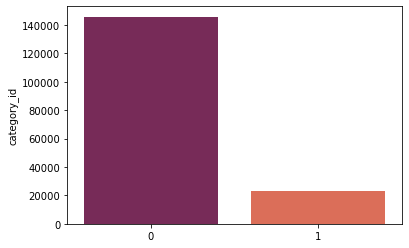

In [9]:
sns.barplot(df_train['category_id'].value_counts().index, df_train['category_id'].value_counts(), palette = 'rocket')

In [10]:
false = df_train[df_train['category_id'] == 0]['user_description']
false.values[0]

'wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙'

In [11]:
true = df_train[df_train['category_id'] == 1]['user_description']
true.values[0]

'Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP'

In [12]:
df_train['user_description'][:5]

0    wednesday addams as a disney princess keepin i...
1    Husband, Father, Columnist & Commentator. Auth...
2    #Christian #Catholic #Conservative #Reagan #Re...
3    #Browns #Indians #ClevelandProud #[]_[] #Cavs ...
4    🖊️Official Twitter handle of Department of Inf...
Name: user_description, dtype: object

In [13]:
def clean_text(user_description):
    user_description = user_description.lower()
    user_description = re.sub('\[.*?\]', '', user_description)
    user_description = re.sub('https?://\S+|www\.\S+', '', user_description)
    user_description = re.sub('<.*?>+', '', user_description)
    user_description = re.sub('[%s]' % re.escape(string.punctuation), '', user_description)
    user_description = re.sub('\n', '', user_description)
    user_description = re.sub('\w*\d\w*', '', user_description)
    
    return user_description

df_train['user_description'] = df_train['user_description'].apply(lambda x: clean_text(x))

df_train['user_description'].head()

0    wednesday addams as a disney princess keepin i...
1    husband father columnist  commentator author o...
2    christian catholic conservative reagan republi...
3           browns indians clevelandproud  cavs resist
4    🖊️official twitter handle of department of inf...
Name: user_description, dtype: object

Build a word cloud

In [14]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

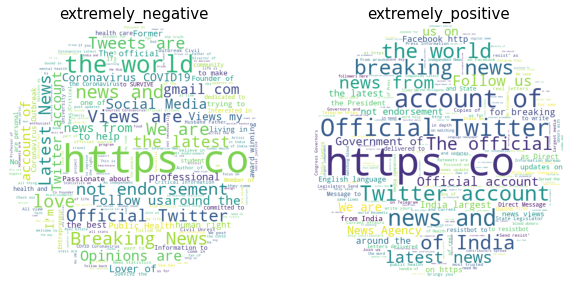

In [15]:
char_mask = np.array(Image.open("1148109.png"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 10])
wordcloud1 = WordCloud(background_color = 'white', width = 600, height = 400, mask = char_mask).generate(" ".join(false))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('extremely_negative', fontsize = 15)

wordcloud2 = WordCloud( background_color='white', width=600, height=400, mask = char_mask).generate(" ".join(true))


ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('extremely_positive', fontsize = 15)
plt.savefig('covid')

Splitting data into train and validation

In [16]:
train_x, valid_x, train_y, valid_y = train_test_split(df_train['user_description'], df_train['category_id'] )

TF-IDF feature generation for a maximum of 5000 features

In [28]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df_train['user_description'])

xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
xtrain_tfidf.data

array([0.16470778, 0.34363596, 0.25249683, ..., 0.72823323, 0.27958774,
       0.62570525])

Model training

In [29]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    return metrics.accuracy_score(predictions, valid_y)

Naive Bayes trainig

In [31]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

In [32]:
accuracy = train_model(naive_bayes.MultinomialNB(alpha=0.2),
xtrain_tfidf, train_y, xvalid_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.9205089323792826


Linear Classifier on Word Level TF IDF Vectors

In [33]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.9341562810974743
